# Imports

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ta.trend import TRIXIndicator
from ta.trend import WMAIndicator
from ta.trend import CCIIndicator
from ta.volume import money_flow_index

# Load Data

In [2]:
appl = yf.Ticker("AAPL")

In [3]:
appl_hist = appl.history(period="max")

# make pandas dataframe
apple_df = pd.DataFrame(appl_hist)

# Create Features

### Function Template for feature creation

In [4]:
def NAME_FEATUERE(df):
    #implementation of the feature-calculation
    # directly add the feature to the dataframe
    # no reurn needed
    pass

### Window Parameter

In [5]:
window = [7, 14, 21, 28]

## Simple Moving Average SMA

In [6]:
def SMA(df):
    for i in window:
        df[f"SMA_{i}"] = df['Close'].rolling(window=i).mean()

## Exponential Moving Average

In [7]:
# a function for the exponential moving average
def EMA(df):
    for i in window:
        df[f"EMA_{i}"] = df['Close'].ewm(span=i, adjust=False).mean()   # adjust checken: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

## Triple Exponential Moving Average (TEMA)

In [8]:
def TRIX(df):
    for i in window:
        trix_values = TRIXIndicator(df['Close'], i).trix()
        df[f"TRIX_{i}"] = trix_values
    return df

## Mony Flow Index

The Money Flow Index (MFI) is a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100.

https://www.investopedia.com/terms/m/mfi.asp

In [9]:
# Function to calculate Money Flow Index
# Uses monex_flow_index from ta library

def MFI(df):
    for i in window:
        df[f"money_flow_index_{i}"] = money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'], window=i)  

## Smoothed RSI

In [10]:
def RSI_smooth(df):
    """
    Momentum indicator
    As per https://www.investopedia.com/terms/r/rsi.asp
    RSI_1 = 100 - (100/ (1 + (avg gain% / avg loss%) ) )
    RSI_2 = 100 - (100/ (1 + (prev_avg_gain*13+avg gain% / prev_avg_loss*13 + avg loss%) ) )

    E.g. if period==6, first RSI starts from 7th index because difference of first row is NA
    http://cns.bu.edu/~gsc/CN710/fincast/Technical%20_indicators/Relative%20Strength%20Index%20(RSI).htm
    https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
    Verified!
    """

    prev_rsi = np.inf
    prev_avg_gain = np.inf
    prev_avg_loss = np.inf
    rolling_count = 0

    def calculate_RSI(series, period):
        # nonlocal rolling_count
        nonlocal prev_avg_gain
        nonlocal prev_avg_loss
        nonlocal rolling_count

        # num_gains = (series >= 0).sum()
        # num_losses = (series < 0).sum()
        # sum_gains = series[series >= 0].sum()
        # sum_losses = np.abs(series[series < 0].sum())
        curr_gains = series.where(series >= 0, 0)  # replace 0 where series not > 0
        curr_losses = np.abs(series.where(series < 0, 0))
        avg_gain = curr_gains.sum() / period  # * 100
        avg_loss = curr_losses.sum() / period  # * 100
        rsi = -1

        if rolling_count == 0:
            # first RSI calculation
            rsi = 100 - (100 / (1 + (avg_gain / avg_loss)))
            # print(rolling_count,"rs1=",rs, rsi)
        else:
            # smoothed RSI
            # current gain and loss should be used, not avg_gain & avg_loss
            rsi = 100 - (100 / (1 + ((prev_avg_gain * (period - 1) + curr_gains.iloc[-1]) /
                                     (prev_avg_loss * (period - 1) + curr_losses.iloc[-1]))))
            # print(rolling_count,"rs2=",rs, rsi)

        # df['rsi_'+str(period)+'_own'][period + rolling_count] = rsi
        rolling_count = rolling_count + 1
        prev_avg_gain = avg_gain
        prev_avg_loss = avg_loss
        return rsi

    diff = df['Close'].diff()[1:]  # skip na
    for i in window:
        df['rsi_' + str(i)] = np.nan
        # df['rsi_'+str(period)+'_own_1'] = np.nan
        rolling_count = 0
        res = diff.rolling(i).apply(calculate_RSI, args=(i,), raw=False)
        df['rsi_' + str(i)][1:] = res

## Williams %R

https://de.wikipedia.org/wiki/Williams_%25R

In [11]:
def WILLIAMS_R(df):
    for i in window:
        highest_high = df['High'].rolling(window=i).max()
        lowest_low = df['Low'].rolling(window=i).min()
        df[f"williams_r_{i}"] = ((highest_high - df['Close']) / (highest_high - lowest_low)) * (-100)

## WMA - Weighted Moving Average

In [12]:
def WMA(df):
    for i in window:
        df[f"wma_{i}"] = WMAIndicator(df['Close'], i).wma()

## HMA - Hull Moving Average

In [13]:
#  ToDo: Formel und Resultate noch zu validieren!!

def HMA(df):
    """
    Berechnet den Hull Moving Average (HMA) und fügt ihn als neue Spalte zum DataFrame hinzu.
    
    """

    for i in window:
        wma1 = 2 * df['Close'].rolling(window=int(i / 2)).mean()
        wma2 = df['Close'].rolling(window=i).mean()
        diff = wma1 - wma2
        hma = diff.rolling(window=int(np.sqrt(i))).mean()
        df[f"hma_{i}"] = hma


## CCI - Commodity Channel Index

In [14]:
def CCI(df):
    for i in window:
        cci_values = CCIIndicator(df['High'], df['Low'], df['Close'], i).cci()
        df[f"cci_{i}"] = cci_values

## Calculation of all features

In [15]:
def create_features(df):
    SMA(df)
    EMA(df)
    TRIX(df)
    MFI(df)
    RSI_smooth(df)
    WILLIAMS_R(df)
    WMA(df)
    HMA(df)
    CCI(df)
    

    print('Feature creation done!')


In [16]:
create_features(apple_df)

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_19854/286843410.py:58: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_19854/286843410.py:58: S

Feature creation done!


In [17]:
apple_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_7,SMA_14,SMA_21,...,wma_21,wma_28,hma_7,hma_14,hma_21,hma_28,cci_7,cci_14,cci_21,cci_28
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087117,0.087117,105728000,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 00:00:00-04:00,171.759995,173.050003,170.059998,172.279999,71106600,0.0,0.0,173.962856,172.415713,175.098095,...,173.668008,174.835467,175.599282,175.136428,170.197998,167.941580,-86.409092,-30.486842,-60.891595,-75.228104
2024-03-25 00:00:00-04:00,170.570007,171.940002,169.449997,170.850006,54288300,0.0,0.0,173.655714,172.467856,174.542381,...,173.281818,174.399827,171.797379,175.111190,171.224117,167.926141,-97.798051,-72.679183,-74.450293,-84.173602
2024-03-26 00:00:00-04:00,170.000000,171.419998,169.580002,169.710007,57388400,0.0,0.0,173.240001,172.510000,173.997143,...,172.842511,173.920518,168.998813,174.774524,171.698642,168.089784,-97.546495,-96.723024,-79.568822,-86.253441


# Labeling

In [18]:
# Function to lable the data
# if i + 11 is the max value in the window, label as BUY
# if i + 11 is the min value in the window, label as SELL
# else label as HOLD
# Idea: Buy when the stock is at its lowest in the window, sell when it is at its highest

# Source: https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3


def get_labels_END(df, windowSize=11):
   labels = [] 
   values = []
   for i in range(len(df.Close) - windowSize): 
      mx = df.Close.iloc[i]
      mn = df.Close.iloc[i]
      mxIndex, mnIndex = i, i
      for j in range(i + 1, i + windowSize + 1): 
         if df.Close.iloc[j] > mx:
               mx = df.Close.iloc[j]
               mxIndex = j
         if df.Close.iloc[j] < mn: 
               mn = df.Close.iloc[j] 
               mnIndex = j

      if mnIndex == i + 11:
         labels.append('SELL')
         values.append(i + 11)
      elif mxIndex == i + 11:
         labels.append('BUY')
         values.append(i + 11)
      else:
         labels.append('HOLD')
         values.append(i + 11)
   
   # Append 11 times a 999 to the end of the labels list
   for i in range(11):
      labels.append(999)

   # Append the labels to the dataframe from the start
   df['Labels_END'] = labels

   # Replace the 999 with NaN
   df['Labels_END'] = df['Labels_END'].replace(999, np.nan)

   print('Labeling END done!')

   return df


In [19]:
# Source: https://towardsdatascience.com/stock-market-action-prediction-with-convnet-8689238feae3


def get_labels_MID(df, col_name, window_size=11):
        """
        Data is labeled as per the logic in research paper
        Label code : BUY => 1, SELL => 0, HOLD => 2
        params :
            df => Dataframe with data
            col_name => name of column which should be used to determine strategy
        returns : nothing - df is modified directly
        """

        row_counter = 0
        total_rows = len(df)
        labels = np.zeros(total_rows)
        labels[:] = np.nan

        while row_counter < total_rows:
            if row_counter >= window_size - 1:
                window_begin = row_counter - (window_size - 1)
                window_end = row_counter
                window_middle = int((window_begin + window_end) / 2)

                min_ = np.inf
                min_index = -1
                max_ = -np.inf
                max_index = -1
                for i in range(window_begin, window_end + 1):
                    price = df.iloc[i][col_name]
                    if price < min_:
                        min_ = price
                        min_index = i
                    if price > max_:
                        max_ = price
                        max_index = i

                if max_index == window_middle:
                    labels[window_middle] = 0
                elif min_index == window_middle:
                    labels[window_middle] = 1
                else:
                    labels[window_middle] = 2

            row_counter = row_counter + 1

        # Add labels to the dataframe
        df['Labels_MID'] = labels

        # Replace the 0, 1, 2 with BUY, SELL, HOLD
        df['Labels_MID'] = df['Labels_MID'].replace(0, 'SELL')
        df['Labels_MID'] = df['Labels_MID'].replace(1, 'BUY')
        df['Labels_MID'] = df['Labels_MID'].replace(2, 'HOLD')
        

        print('Labeling MID done!') 

In [20]:
get_labels_MID(apple_df, 'Close')
get_labels_END(apple_df)

Labeling MID done!
Labeling END done!


,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_7,SMA_14,SMA_21,...,hma_7,hma_14,hma_21,hma_28,cci_7,cci_14,cci_21,cci_28,Labels_MID,Labels_END
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD
1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD
1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087117,0.087117,105728000,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD
1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD
1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 00:00:00-04:00,171.759995,173.050003,170.059998,172.279999,71106600,0.0,0.0,173.962856,172.415713,175.098095,...,175.599282,175.136428,170.197998,167.941580,-86.409092,-30.486842,-60.891595,-75.228104,NaN,NaN
2024-03-25 00:00:00-04:00,170.570007,171.940002,169.449997,170.850006,54288300,0.0,0.0,173.655714,172.467856,174.542381,...,171.797379,175.111190,171.224117,167.926141,-97.798051,-72.679183,-74.450293,-84.173602,NaN,NaN
2024-03-26 00:00:00-04:00,170.000000,171.419998,169.580002,169.710007,57388400,0.0,0.0,173.240001,172.510000,173.997143,...,168.998813,174.774524,171.698642,168.089784,-97.546495,-96.723024,-79.568822,-86.253441,NaN,NaN


Text(0.5, 1.0, 'Labels END')

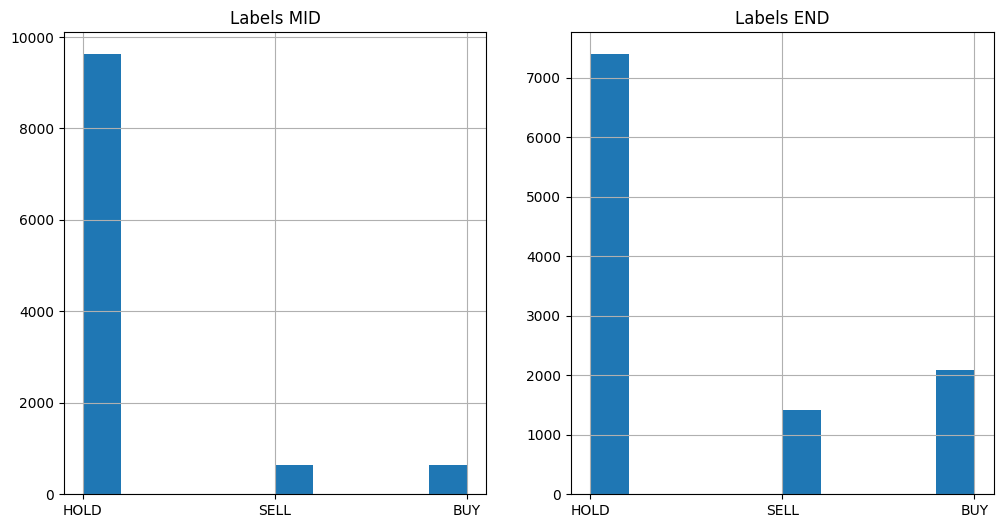

In [21]:
# make a subplot of the labeles MID and END
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
apple_df['Labels_MID'].hist(ax=ax[0])
apple_df['Labels_END'].hist(ax=ax[1])

# add a title to the subplot
ax[0].set_title('Labels MID')
ax[1].set_title('Labels END')


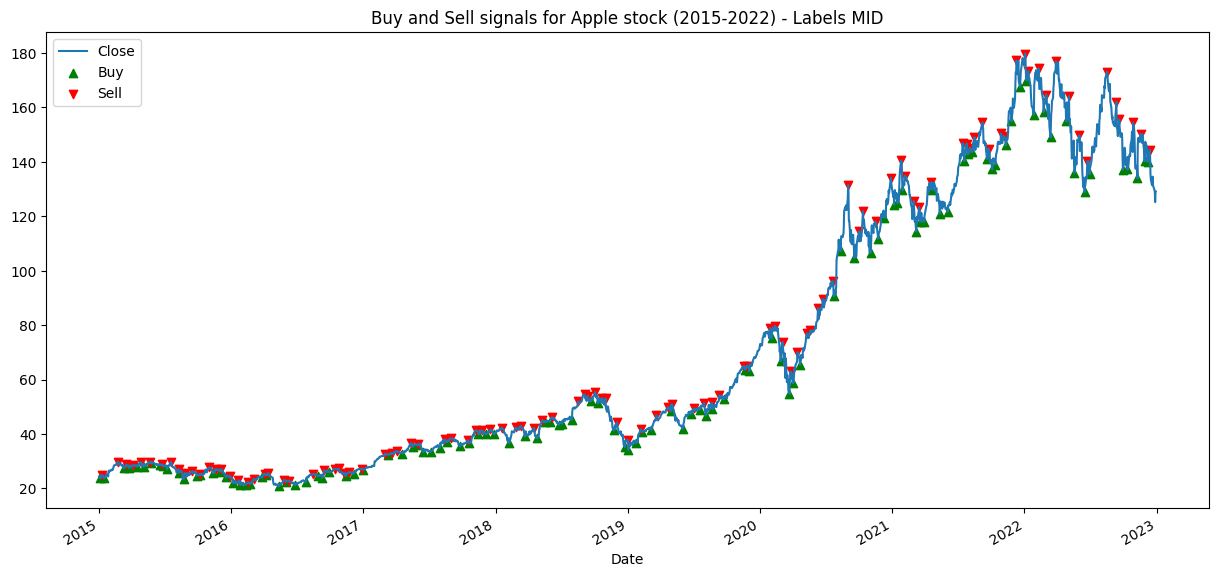

In [22]:
plt.figure(figsize=(15, 7))

# add buy and sell signals
# buy = green, sell = red
buy = apple_df[(apple_df['Labels_MID'] == 'BUY') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
sell = apple_df[(apple_df['Labels_MID'] == 'SELL') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
apple_df['Close']['2015':'2022'].plot()
plt.scatter(buy.index, buy['Close'], color='g', marker='^', alpha=1)
plt.scatter(sell.index, sell['Close'], color='r', marker='v', alpha=1)
plt.title('Buy and Sell signals for Apple stock (2015-2022) - Labels MID')
plt.legend(['Close', 'Buy', 'Sell'])
plt.show()



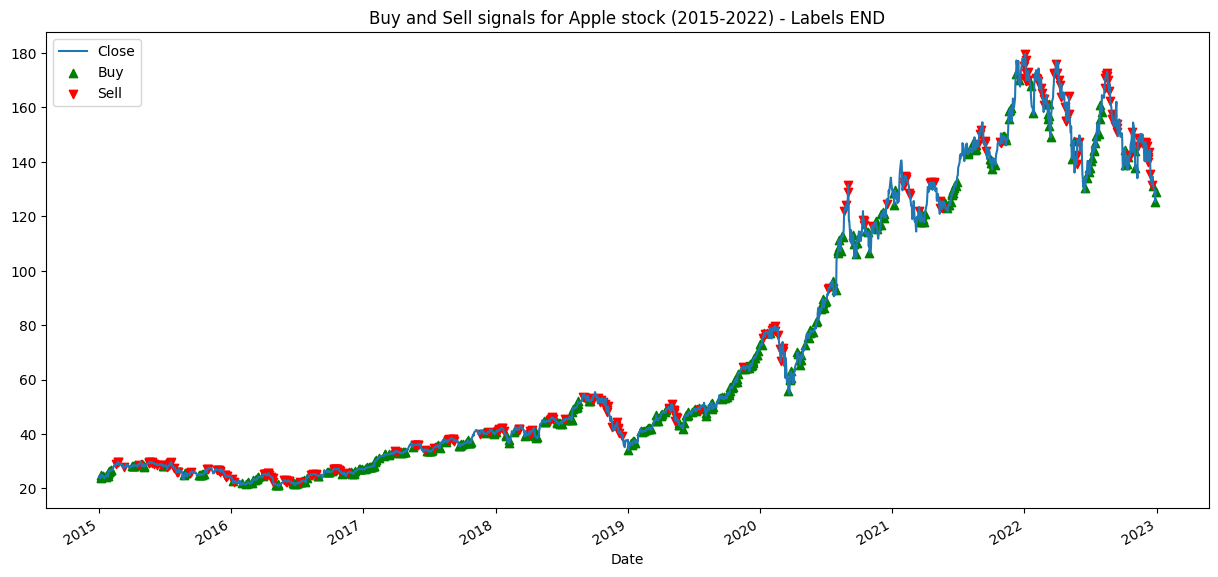

In [23]:
plt.figure(figsize=(15, 7))

# add buy and sell signals
# buy = green, sell = red
buy = apple_df[(apple_df['Labels_END'] == 'BUY') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
sell = apple_df[(apple_df['Labels_END'] == 'SELL') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
apple_df['Close']['2015':'2022'].plot()
plt.scatter(buy.index, buy['Close'], color='g', marker='^', alpha=1)
plt.scatter(sell.index, sell['Close'], color='r', marker='v', alpha=1)
plt.title('Buy and Sell signals for Apple stock (2015-2022) - Labels END')
plt.legend(['Close', 'Buy', 'Sell'])
plt.show()


## Feature Engineering

The reason behind having this step in our pipeline is that Feature engineering involves creating, transforming, or selecting the most relevant variables in your dataset to improve model performance. This process is critical because it enables the model to learn from the data more effectively, leading to better predictions and insights. Feature selection, in particular, trims down the feature set to keep only the most valuable attributes, reducing complexity, computation time, and the risk of overfitting. In essence, these techniques streamline the modelling process, making it more accurate, interpretable, and efficient, while also saving time and resources.
First, we Normalize our data set because Normalizing a dataset is crucial to ensure that all features are on a consistent scale, preventing one feature from dominating the analysis, improving model convergence, aiding in the interpretation of feature importance, making distance-based algorithms more reliable, and aligning with assumptions of regularisation techniques, all of which contribute to more effective and robust data analysis and machine learning.
Then we will just apply a small filter of variance with a threshold of 0.1 i.e. any feature which has a variance less than or equal to 0.1 will be removed from the dataset as having this low variance does not contribute much to detecting the trend in the dataset.

In [27]:
list_features = list(apple_df.loc[:, 'Open':'cci_28'].columns)
print('Total number of features', len(list_features))

Total number of features 43


In [28]:
### just copied from: https://towardsdatascience.com/stock-market-action-prediction-with-convnet-8689238feae3
### needs to be reworked and adapted to the features we want to use
### create function for this


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter

df = apple_df.dropna()

list_features = list(df.loc[:, 'Open':'cci_28'].columns)  # needs to be changed to the features you want to use
print('Total number of features', len(list_features))
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'Open':'cci_28'].values, df['Labels_MID'].values, train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=True, stratify=df['Labels_MID'].values)

train_split = 0.8

print('train_split =',train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)
mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))


Total number of features 43
train_split = 0.8
Shape of x, y train/cv/test (6924, 43) (6924,) (1732, 43) (1732,) (2165, 43) (2165,)


# Feature Selection

Now the main part is that we will calculate the importance of each feature by using Random Forest Classifier and then reduce the feature size to 81.

A rough idea of how random forest works is for each decision point (split) in each tree, the Random Forest algorithm measures the decrease in impurity(Gini impurity) resulting from the split. The impurity reduction brought about by each feature is averaged across all the trees in the forest. Features that consistently reduce impurity more effectively when used in splits are considered more important

## Feature Importamce in Prediction

Used mutual info classification for creating heat map for our image. Basically it tells us which part of the image is most useful to the model (will explain this part more in further ). (https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3)

> keine Ahnung was er damit meint und warum er das macht??!

## Image Creation

In [26]:
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))


NameError: name 'num_features' is not defined

## CNN

## Trading Bot Implementation